In [ ]:
from analyzer import Analyzer

self = Analyzer("ctj1uzfo", resume_last=False) # If resume_last False, use BEST checkpoint instead

0it [00:00, ?it/s]


Accuracy: 54.10%
Accuracy: 62.50%
Accuracy: 67.19%
Accuracy: 45.31%
Accuracy: 53.12%


In [ ]:
from sklearn.base import BaseEstimator
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import torch
from sklearn.manifold import TSNE
from clustering_wrappers import ClusterAlgWrapper
from typing import Optional, Type


def plot_clusters(self, cluster_alg: Optional[Type[ClusterAlgWrapper]] = None, save_path: Optional[str] = None, dim_reduc: Type[BaseEstimator] = TSNE, **cluster_alg_kwargs):
    """
    :param cluster_alg: Type of a clustering algorithm to use. If provided, this will be fitted for every pooling layer
    :return:
    """
    pool_acts_train = self.train_info.pooling_activations
    masks_train = [self.train_data.mask] + self.train_info.all_batch_or_mask
    pool_acts_test = self.test_info.pooling_activations
    masks_test = [self.test_data.mask] + self.test_info.all_batch_or_mask
    for i in range(len(pool_acts_train)):
        if cluster_alg is None:
            if not hasattr(self.model.graph_network.pool_blocks[i], "cluster_alg"):
                break
            cluster_alg_used = self.model.graph_network.pool_blocks[i].cluster_alg
        else:
            cluster_alg_used = cluster_alg(**cluster_alg_kwargs)
            cluster_alg_used.fit(pool_acts_train[i][masks_train[i]])

        num_train_nodes = pool_acts_train[i][masks_train[i]].shape[0]
        num_nodes = num_train_nodes + pool_acts_test[i][masks_test[i]].shape[0]
        all_points = torch.cat((pool_acts_train[i][masks_train[i]], pool_acts_test[i][masks_test[i]], cluster_alg_used.centroids), dim=0).detach().cpu()
        assignments = cluster_alg_used.predict(all_points).cpu()

        coords = dim_reduc(n_components=2).fit_transform(X=all_points)

        fig, ax = plt.subplots()
        # o p s
        ax.scatter(coords[:num_train_nodes, 0], coords[:num_train_nodes, 1],
                   c=self.colors[assignments[:num_train_nodes]],
                   marker='s', s=2, label="Train embeddings")
        ax.scatter(coords[num_train_nodes:num_nodes, 0], coords[num_train_nodes:num_nodes, 1],
                   c=self.colors[assignments[num_train_nodes:num_nodes]],
                   marker='p', s=2, label="Test embeddings")
        ax.scatter(coords[num_nodes:, 0], coords[num_nodes:, 1],
                   c=self.colors[assignments[num_nodes:]],
                   marker='o', s=10, label="Centroids")
        fig.show()
        if save_path is not None:
            fig.savefig(f"{save_path}_{i}.pdf", bbox_inches='tight')



In [3]:
plot_clusters(self, save_path="img/clusters")

TypeError: expected Tensor as element 2 in argument 0, but got NoneType

C:\Users\jonas\AppData\Local\Temp\ipykernel_6132\933180381.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


IndexError: index 90 is out of bounds for axis 0 with size 14

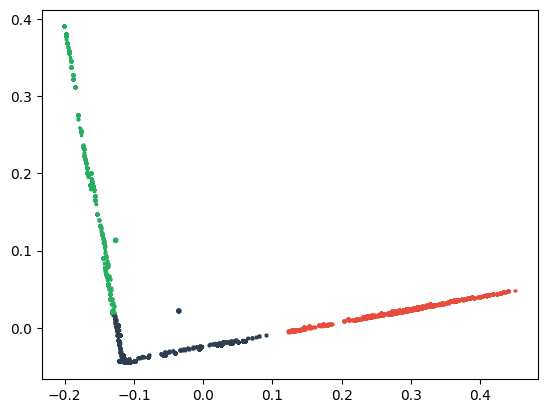

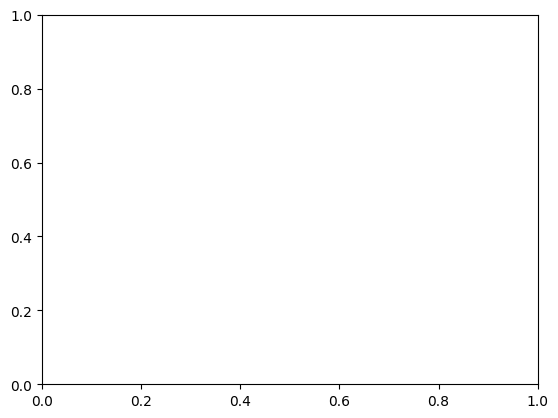

In [6]:
from clustering_wrappers import MeanShiftWrapper

plot_clusters(self, MeanShiftWrapper, save_path="img/mean_shift_clusters", range=0.1, dim_reduc=PCA)

In [ ]:
from typing import List


# https://academic.oup.com/bioinformatics/article/37/15/2212/5962080
def jaccard_index(assignment1: torch.Tensor, assignment2: torch.Tensor):
    """

    :param assignment1: [num_points] (containing integer assignments {0, ..., num_clusters1 - 1})
    :param assignment2: [num_points] (containing integer assignments {0, ..., num_clusters2 - 1})
    :return: [num_clusters_1, num_clusters_2]
    """
    num_clusters1 = torch.max(assignment1)
    num_clusters2 = torch.max(assignment2)
    # [num_points, num_clusters1] one-hot encoding
    one_hot1 = assignment1[:, None] == torch.arange(num_clusters1)[None, :]
    # [num_points, num_clusters1] one-hot encoding
    one_hot2 = assignment2[:, None] == torch.arange(num_clusters2)[None, :]
    # [num_clusters1, num_clusters2] produced from [num_points, num_clusters1, num_clusters2] where [i, j, k] == 1 iff. point i is member of cluster j in assignment1 and k in assignment 2
    intersec = torch.sum(torch.logical_and(one_hot1[:, :, None], one_hot2[:, None, :]), dim=0)
    union = torch.sum(torch.logical_or(one_hot1[:, :, None], one_hot2[:, None, :]), dim=0)
    return intersec / union


def jaccard_purity(samples: List[torch.Tensor]) -> float:
    """

    :param samples: List with entries of size [num_points] that contain mapppings to clusters in form of integers
    :return:
    """

def jaccard_cluster_score(num_iterations=10, keep_prob=0.8):
    return jaccard_purity([])



In [4]:
analyzer.calculate_concept_completeness()

NotImplementedError: 